In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Preparing data

In [3]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [4]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [5]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [6]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords.sort()

In [7]:
print(keywords)

['Beam me up,\\? Scotty', 'Chekhov', 'Crusher', 'Delta Vega', 'Highly illogical', 'I have been and always shall be your friend', "I'm a doctor,\\? not a", "I'm giving her all she's got,\\? Captain", 'KHAAA\\+N', 'Kirk', 'Klingon', 'Kobayashi Maru', 'LLAP', 'Live long and prosper', 'McCoy', 'Nero', 'Nuclear wessels', 'Nurse Chapel', 'Orion', 'Picard', 'Pike', 'Prime Directive', 'Resistance is futile', 'Romulan', 'Romulan Narada', 'Sarek', 'Scotty', 'Set phasers to stun', 'Space,\\? The Final Frontier', 'Spock', 'Star Trek', 'Star fleet', 'Stardate', 'Starship Enterprise', 'Sulu', 'The needs of the many outweigh the needs of the few', 'Transporter beam', 'Uhura', 'Vulcan', 'Vulcan Salute', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'to boldly go where no man has gone before']


In [8]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 28.5 s, sys: 1.07 s, total: 29.6 s
Wall time: 29.6 s


In [9]:
len(reddit_df)

2669814

In [10]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Subreddits

In [11]:
reddit_df['subreddit'].nunique()

24076

In [12]:
reddit_df['subreddit'].value_counts()

AdviceAnimals            216848
startrek                 182534
AskReddit                179550
fantasyfootball           92045
movies                    65545
nfl                       62410
Smite                     58973
DaystromInstitute         57314
sto                       44103
funny                     37788
doctorwho                 35282
pics                      35054
scifi                     33434
Planetside                27387
todayilearned             25934
GlobalOffensiveTrade      25360
motorcycles               24585
SquaredCircle             20231
Civcraft                  19555
IAmA                      18502
gaming                    18339
atheism                   18110
grandorder                16730
chicagobulls              16501
videos                    16271
nba                       16193
PercyJacksonRP            15635
CFB                       15368
WTF                       13752
TheDescendantsOfRome      13213
                          ...  
Motorcyc

In [13]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

## startrek

In [14]:
subreddit = 'startrek'

peaks = ['2009-05-01', '2012-12-01', '2013-05-01', '2016-07-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

title = 'Number of comments on subreddit \'' + subreddit + '\' by month'

In [15]:
%%time

subreddit_df = reddit_df[reddit_df['subreddit'] == subreddit]

CPU times: user 288 ms, sys: 104 ms, total: 392 ms
Wall time: 390 ms


In [16]:
len(subreddit_df)

182534

In [17]:
subreddit_by_month = pd.Series(subreddit_df.groupby('month')['id'].count())
subreddit_by_month.index.name = None

In [18]:
show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

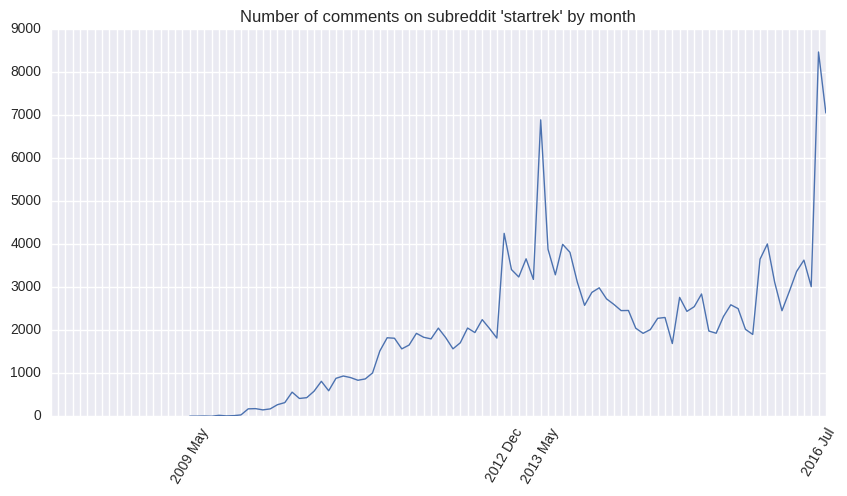

In [19]:
ax = subreddit_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title=title,
)
ax.set_xticklabels(show_dates);

### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [20]:
peaks

[Timestamp('2009-05-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2012-12-01

In [21]:
date = '2012-12-01'

In [22]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [23]:
len(subreddit_date_df)

4250

In [24]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.93 s, sys: 16.1 ms, total: 2.94 s
Wall time: 2.94 s


In [25]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [26]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"not when the motto of all klingon comics is: ""...",0.70,0.60
1,sulu didn't have a japanese accent. he's from...,0.00,0.00
2,"i've always been a fan of the ""everything in l...",0.17,0.35
3,uber star wars fan here.... i would love to ha...,0.62,0.60
4,how could you forget klingon academy,0.00,0.00


In [27]:
sentiment_df['sentiment'].mean()

0.10905434748800666

In [28]:
sentiment_df['sentiment'].std()

0.22151434367769657

In [29]:
sentiment_df['subjectivity'].mean()

0.45640362011347496

In [30]:
sentiment_df['subjectivity'].std()

0.23485023480906297

#### 2013-05-01

In [31]:
date = '2013-05-01'

In [32]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [33]:
len(subreddit_date_df)

6886

In [34]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 4.69 s, sys: 0 ns, total: 4.69 s
Wall time: 4.68 s


In [35]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [36]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"holy moire, kirk!",0.00,0.00
1,abrams' movie is easily one of the best trek m...,0.61,0.61
2,"guys guys guys, new star trek is good. old (tn...",0.21,0.30
3,"eh, there's some good one-off ones. i really l...",0.40,0.61
4,"i don't think he's ""overacting"", at least as f...",-0.02,0.48


In [37]:
sentiment_df['sentiment'].mean()

0.11140917678554957

In [38]:
sentiment_df['sentiment'].std()

0.2179435356519433

In [39]:
sentiment_df['subjectivity'].mean()

0.46197876374164276

In [40]:
sentiment_df['subjectivity'].std()

0.22817620986639806

#### 2016-07-01

In [41]:
date = '2016-07-01'

In [42]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [43]:
len(subreddit_date_df)

8462

In [44]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 6.17 s, sys: 76 µs, total: 6.17 s
Wall time: 6.16 s


In [45]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [46]:
sentiment_df.head()

,body,sentiment,subjectivity
0,vulcan women would not wear uncomfortable shoes.,-0.50,1.00
1,then i wouldn't bother. - - i love the origin...,0.15,0.41
2,he's done it for a few lines in the previous m...,-0.03,0.27
3,yes! still a great series! - - it was old wh...,0.15,0.47
4,beam me up scotty.,0.00,0.00


In [47]:
sentiment_df['sentiment'].mean()

0.10954424826620877

In [48]:
sentiment_df['sentiment'].std()

0.21422561804654525

In [49]:
sentiment_df['subjectivity'].mean()

0.46977461486056721

In [50]:
sentiment_df['subjectivity'].std()

0.21940826297514379